In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
from pyod.models.iforest import IForest
import numpy as np
from sklearn.metrics import classification_report
from pyod.models.xgbod import XGBOD
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.lscp import LSCP

from sklearn.metrics import accuracy_score
from pyod.models.pca import PCA
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.feature_bagging import FeatureBagging
import warnings
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import evaluate_print
from sklearn.preprocessing import StandardScaler

from scipy.stats import ConstantInputWarning

warnings.simplefilter("ignore", ConstantInputWarning)


In [3]:
df=pd.read_csv("/Users/saikarthik/Desktop/Nexus-S1 Deakin /cleaned.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'timestamp', 'value'], dtype='object')

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)


In [6]:
df.columns

Index(['timestamp', 'value'], dtype='object')

In [7]:
mean_value = df['value'].mean()
std_dev_value = df['value'].std()

In [8]:
threshold_upper = mean_value + (1.25 * std_dev_value)
threshold_lower = mean_value -( 3 * std_dev_value)

In [9]:
def label_anomalies(value):
    if value > threshold_upper or value < threshold_lower:
        return 1  
    else:
        return 0  



In [10]:
df['true_labels'] = df['value'].apply(label_anomalies)


In [11]:
df["true_labels"].value_counts()

true_labels
0    22042
1      653
Name: count, dtype: int64

In [12]:
scaler = StandardScaler()
X = df[['value']].values
X_scaled = scaler.fit_transform(X)
X=X_scaled

# Essembled Based 

In [13]:
detectors = [
    KNN(),
    IForest(),
    LOF()
]


In [27]:
clf_lscp = LSCP(detectors,30,1.0,0.1 )  


In [29]:
clf_lscp.fit(X)


/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/pyod/models/lscp.py:314: UserWarning: Local min features equals local max features; use all features instead.
  warnings.warn("Local min features equals local max features; "
/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/pyod/models/lscp.py:314: UserWarning: Local min features equals local max features; use all features instead.
  warnings.warn("Local min features equals local max features; "
/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/pyod/models/lscp.py:314: UserWarning: Local min features equals local max features; use all features instead.
  warnings.warn("Local min features equals local max features; "
/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/pyod/models/lscp.py:314: UserWarning: Local min features equals local max features; use all features instead.
  warnings.warn("Local min features equals local max features; "
/Users/saikarthik/tensorflow-test/en

TypeError: `bins` must be an integer, a string, or an array

In [23]:
y_pred_lscp= clf_lscp.labels_  
y_scores_lscp = clf_lscp.decision_scores_ 

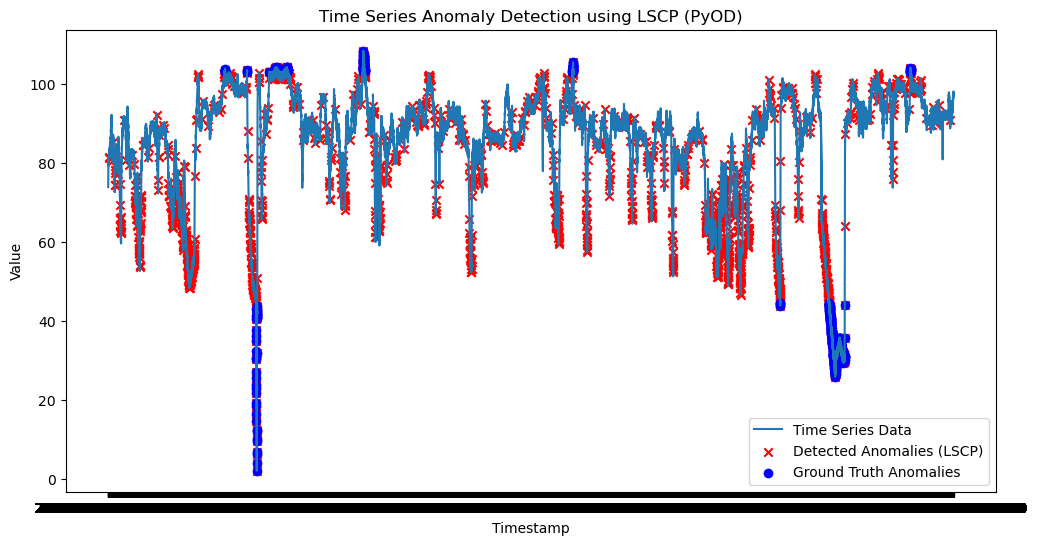

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Time Series Data')
plt.scatter(df['timestamp'][y_pred_lscp == 1], df['value'][y_pred_lscp == 1], 
            color='red', marker='x', label='Detected Anomalies (LSCP)')
plt.scatter(df['timestamp'][df['true_labels'] == 1], df['value'][df['true_labels'] == 1], 
            color='blue', marker='o', label='Ground Truth Anomalies')
plt.title('Time Series Anomaly Detection using LSCP (PyOD)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


In [25]:
print(classification_report(df['true_labels'], y_pred_lscp))
accuracy_lscp = accuracy_score(df['true_labels'], y_pred_lscp)


              precision    recall  f1-score   support

           0       0.99      0.92      0.95     22042
           1       0.20      0.68      0.31       653

    accuracy                           0.91     22695
   macro avg       0.59      0.80      0.63     22695
weighted avg       0.97      0.91      0.93     22695



In [26]:
accuracy_lscp*100

91.05089226701917

## Isolation Forest 

In [12]:
clf = IForest(contamination=0.1, random_state=42)

In [13]:
clf.fit(X)


IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)

In [14]:
y_pred_if = clf.predict(X) 

In [15]:
y_scores_if= clf.decision_function(X)

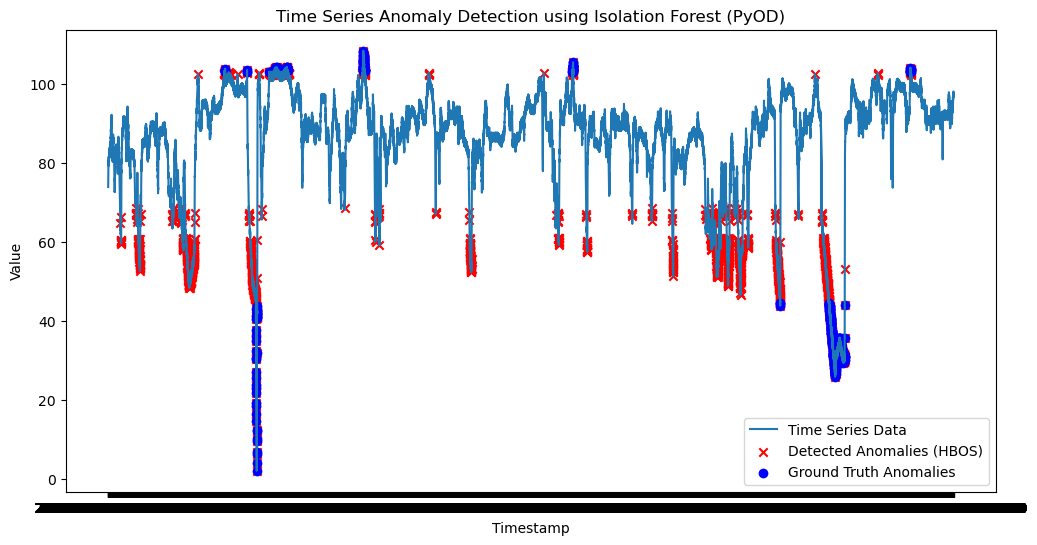

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Time Series Data')
plt.scatter(df['timestamp'][y_pred_if== 1], df['value'][y_pred_if== 1], 
            color='red', marker='x', label='Detected Anomalies (HBOS)')
plt.scatter(df['timestamp'][df['true_labels'] == 1], df['value'][df['true_labels'] == 1], 
            color='blue', marker='o', label='Ground Truth Anomalies')
plt.title('Time Series Anomaly Detection using Isolation Forest (PyOD)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [17]:
print(classification_report(df['true_labels'], y_pred_if))


              precision    recall  f1-score   support

           0       1.00      0.93      0.96     22042
           1       0.29      1.00      0.45       653

    accuracy                           0.93     22695
   macro avg       0.64      0.96      0.70     22695
weighted avg       0.98      0.93      0.95     22695



In [18]:
accuracy = accuracy_score(df['true_labels'], y_pred_if)
accuracy*100

92.8927076448557

# Proximity Based 

## HBOS

In [19]:
clf_hbos = HBOS()
clf_hbos.fit(X)

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [20]:
y_predict_hbos = clf_hbos.predict(X)

In [21]:
y_scores_hbos=clf_hbos.decision_function(X)

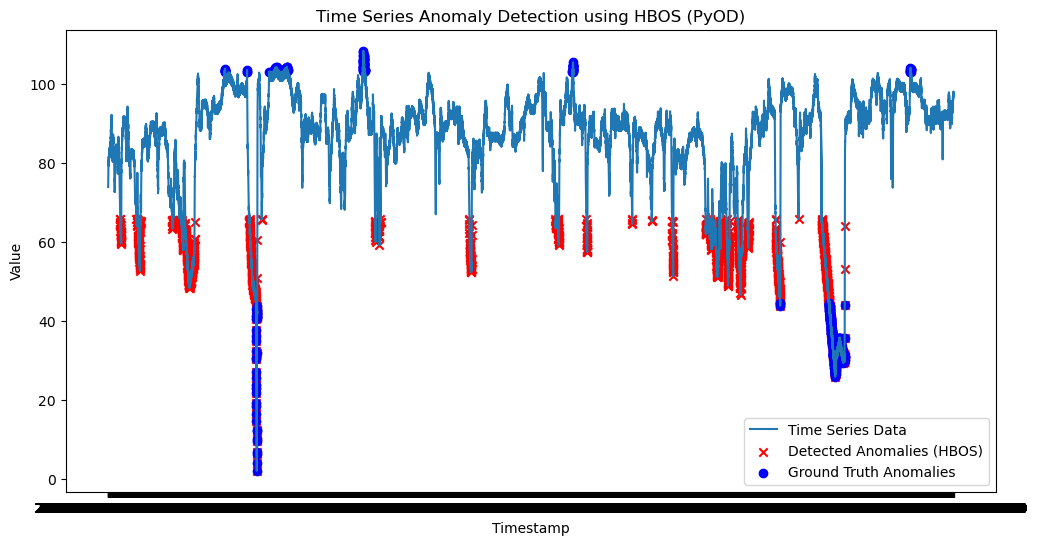

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Time Series Data')
plt.scatter(df['timestamp'][y_predict_hbos == 1], df['value'][y_predict_hbos == 1], 
            color='red', marker='x', label='Detected Anomalies (HBOS)')
plt.scatter(df['timestamp'][df['true_labels'] == 1], df['value'][df['true_labels'] == 1], 
            color='blue', marker='o', label='Ground Truth Anomalies')
plt.title('Time Series Anomaly Detection using HBOS (PyOD)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
print(classification_report(df['true_labels'], y_predict_hbos ))


              precision    recall  f1-score   support

           0       0.99      0.92      0.95     22042
           1       0.21      0.71      0.32       653

    accuracy                           0.91     22695
   macro avg       0.60      0.81      0.64     22695
weighted avg       0.97      0.91      0.94     22695



In [24]:
accuracy = accuracy_score(df['true_labels'], y_predict_hbos)
accuracy*100

91.45186164353382

## KNN 

In [25]:
clf_knn = KNN()
clf_knn.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [26]:
y_predict_knn = clf_knn.predict(X)
y_scores_knn = clf_knn.decision_function(X)

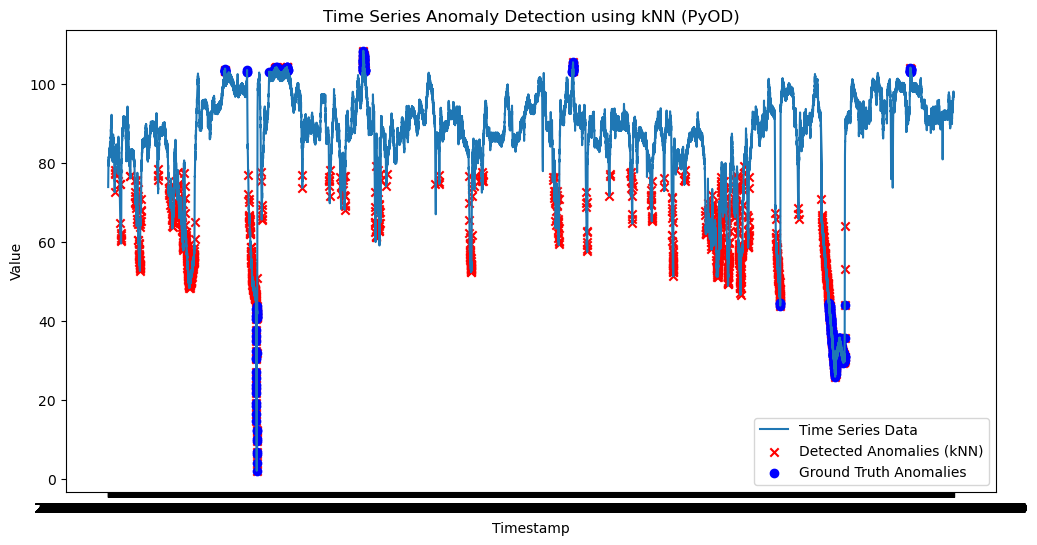

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Time Series Data')
plt.scatter(df['timestamp'][y_predict_knn == 1], df['value'][y_predict_knn == 1], 
            color='red', marker='x', label='Detected Anomalies (kNN)')
plt.scatter(df['timestamp'][df['true_labels'] == 1], df['value'][df['true_labels'] == 1], 
            color='blue', marker='o', label='Ground Truth Anomalies')
plt.title('Time Series Anomaly Detection using kNN (PyOD)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [28]:
print(classification_report(df['true_labels'], y_predict_knn))


              precision    recall  f1-score   support

           0       0.99      0.95      0.97     22042
           1       0.29      0.74      0.42       653

    accuracy                           0.94     22695
   macro avg       0.64      0.84      0.69     22695
weighted avg       0.97      0.94      0.95     22695



In [29]:
accuracy = accuracy_score(df['true_labels'], y_predict_knn)
accuracy*100

94.10002203128442

# Linear Model

In [30]:
clf_pca = PCA(n_components=1, contamination=0.1)
clf_pca.fit(X_scaled)


PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=1,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [31]:
y_predict_pca = clf_pca.predict(X_scaled)
y_scores_pca = clf_pca.decision_function(X_scaled)

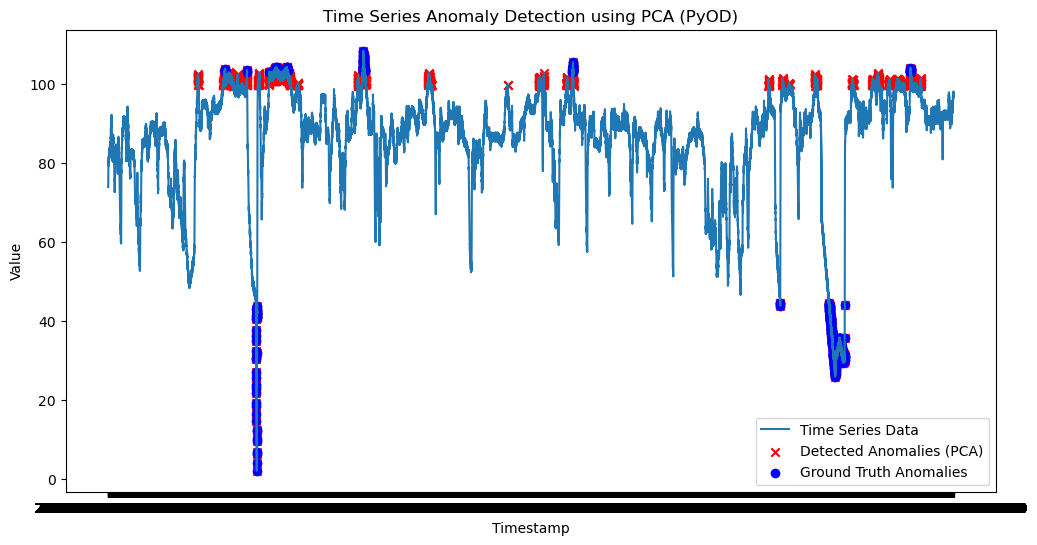

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Time Series Data')
plt.scatter(df['timestamp'][y_predict_pca == 1], df['value'][y_predict_pca == 1], 
            color='red', marker='x', label='Detected Anomalies (PCA)')
plt.scatter(df['timestamp'][df['true_labels'] == 1], df['value'][df['true_labels'] == 1], 
            color='blue', marker='o', label='Ground Truth Anomalies')
plt.title('Time Series Anomaly Detection using PCA (PyOD)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [33]:
print(classification_report(df['true_labels'], y_predict_pca))
accuracy = accuracy_score(df['true_labels'], y_predict_pca)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     22042
           1       0.29      1.00      0.45       653

    accuracy                           0.93     22695
   macro avg       0.64      0.96      0.70     22695
weighted avg       0.98      0.93      0.95     22695



In [34]:
accuracy *100

92.87508261731658

## MCD 

In [35]:
clf_mcd = MCD()
clf_mcd.fit(X)

MCD(assume_centered=False, contamination=0.1, random_state=None,
  store_precision=True, support_fraction=None)

In [36]:
y_predict_mcd = clf_mcd.predict(X) # type: ignore
y_scores_mcd = clf_mcd.decision_function(X) # type: ignore

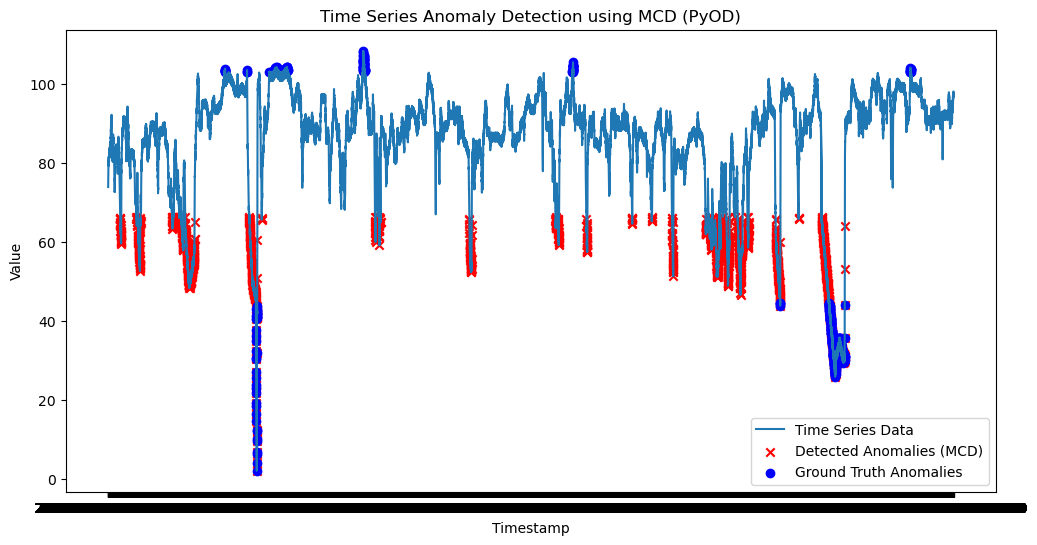

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Time Series Data')
plt.scatter(df['timestamp'][y_predict_mcd == 1], df['value'][y_predict_mcd == 1], 
            color='red', marker='x', label='Detected Anomalies (MCD)')
plt.scatter(df['timestamp'][df['true_labels'] == 1], df['value'][df['true_labels'] == 1], 
            color='blue', marker='o', label='Ground Truth Anomalies')
plt.title('Time Series Anomaly Detection using MCD (PyOD)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [38]:
print(classification_report(df['true_labels'], y_predict_mcd))
accuracy = accuracy_score(df['true_labels'], y_predict_mcd)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     22042
           1       0.20      0.71      0.32       653

    accuracy                           0.91     22695
   macro avg       0.60      0.81      0.63     22695
weighted avg       0.97      0.91      0.93     22695



In [39]:
accuracy*100

91.19189248733201

# Neural Network 

## Autoencoder

CODE (https://drive.google.com/drive/u/2/folders/14CT2ElG5eTvJm7ArN6WV6_XlRfqNJD6X)